In [1]:
using LowRankModels
using PyPlot
using CSV
using ProgressMeter
using Statistics
using StatsBase
using LaTeXStrings
using Printf
using JLD2
using Test
using ScikitLearn.CrossValidation: KFold

┌ Info: Precompiling LowRankModels [15d4e49f-4837-5ea3-a885-5b28bfa376dc]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **

┌ Info: Precompiling ScikitLearn [3646fa90-6ef7-5e7e-9f22-8aca16db6324]
└ @ Base loading.jl:1273


# Load Henry coefficient matrix `H`

see `CreateMatrix.ipynb` for Python code that queries the NIST database for the adsorption data and fits Henry's law to the adsorption data to identify the Henry constant.

the gases run along the columns, the materials run along the rows, and the entries are the Henry coefficients identified from experimental adsorption data.

* the values of the Henry coefficients were `log10`-transformed, then,
* the columns of `H` were standardized (mean zero, unit variance)

In [3]:
@load joinpath("data", "logH_matrix_materials_and_gases.jld2") H master_list_of_materials master_list_of_gases MSE
materials = String.(deepcopy(master_list_of_materials)) # list of materials, order corresponding to rows in H
gases = String.(deepcopy(master_list_of_gases)) # list of gases, order corresponding to cols in H

nm, ng = size(H) #no. of materials and gases
@show nm
@show ng

@assert length(materials) == nm && length(gases) == ng

nm = 214
ng = 41


In [4]:
println("fraction values missing: ", sum(ismissing.(H)) / length(H))

fraction values missing: 0.8610667882379759


In [5]:
@printf("Maximum value in H is: %.3f\n", maximum(skipmissing(H)))
@printf("Minimum value in H is: %.3f\n", minimum(skipmissing(H)))

Maximum value in H is: 4.853
Minimum value in H is: -4.115


## sort rows, cols according to the number of observations
... and sort `materials` and `gases` accordingly!

In [15]:
# This is not working properly 16/2/2020 - Arni
function sort_rows_cols_acc_to_nb_obs!(H::Array{Union{Float64, Missing}, 2},
                                       MSE::Array{Union{Float64, Missing}, 2},
                                       materials::Array{String, 1}, 
                                       gases::Array{String, 1})
    nm, ng = size(H)
    @assert size(MSE) == size(H)
    
    # rows
    nb_obs = [sum(.! ismissing.(H[i, :])) for i = 1:nm]
    ids_reorder = sortperm(nb_obs, rev=true)
    H .= H[ids_reorder, :]
    MSE .= MSE[ids_reorder, :]
    materials .= materials[ids_reorder]

    # cols
    nb_obs = [sum(.! ismissing.(H[:, j])) for j = 1:ng]
    ids_reorder = sortperm(nb_obs, rev=true)
    H .= H[:, ids_reorder]
    MSE .= MSE[:, ids_reorder]
    gases .= gases[ids_reorder]

    # sanity check: successive rows/cols hv more/equal missing values
    for i = 1:nm-1
        @assert sum(ismissing.(H[i, :])) <= sum(ismissing.(H[i+1, :]))
    end
    for j = 1:ng-1
        @assert sum(ismissing.(H[:, j])) <= sum(ismissing.(H[:, j+1]))
    end
    return nothing
end

sort_rows_cols_acc_to_nb_obs!(H, MSE, materials, gases)

In [16]:
# tests for `sort_rows_cols_acc_to_nb_obs!`
H_test = [missing missing    1   missing missing;
             5.0     5       5       5      5;
             3    missing    3       3     missing;
             4       4        4    missing     4
         ]
gases_test = ["gas$i" for i = 1:5]
materials_test = ["mof$i" for i = 1:4]

sort_rows_cols_acc_to_nb_obs!(H_test, deepcopy(H_test), materials_test, gases_test)


@test all(skipmissing([  5.0     5.       5.       5.        5.;
    4.      4.       4.      missing  4.;
    3.      3.      missing  3.     missing;
    1.    missing  missing missing missing] .== H_test))

@test gases_test == ["gas3", "gas1", "gas2", "gas4", "gas5"]
@test materials_test == ["mof2", "mof4", "mof3", "mof1"]

Test Passed

In [17]:
println("min # observations in a row: ", sum(.! ismissing.(H[end, :])))
println("min # observations in a col: ", sum(.! ismissing.(H[:, end])))

min # observations in a row: 4
min # observations in a col: 4


## prune matrix by selecting rows/cols with the most observations

In [21]:
# nm, ng = size(H) # use full matrix
nm = 75
ng = 20

H = H[1:nm, 1:ng]
MSE = MSE[1:nm, 1:ng]
materials = materials[1:nm]
gases = gases[1:ng];

# once we ablate certain rows/cols: last row/ last col may not have min # of observations
sort_rows_cols_acc_to_nb_obs!(H, MSE, materials, gases)

println("min # observations in a row: ", sum(.! ismissing.(H[end, :])))
println("min # observations in a col: ", sum(.! ismissing.(H[:, end])))
# TODO copy Arni's code for viz of frequency of observations gases and mofs

min # observations in a row: 2
min # observations in a col: 10


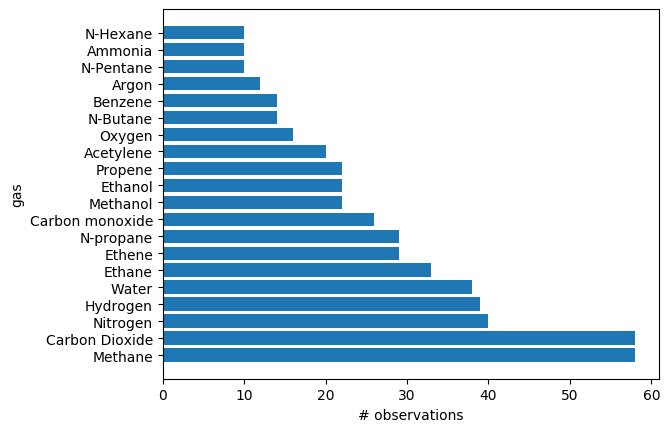

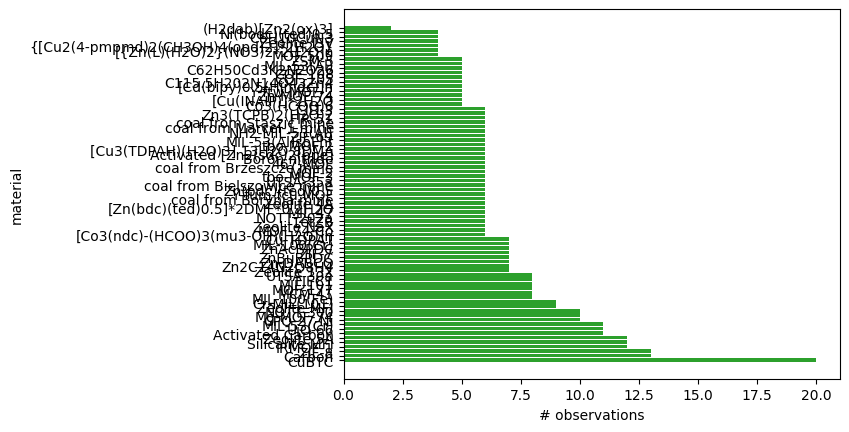

PyObject Text(24.000000000000043, 0.5, 'material')

In [22]:
plt.figure()
barh(gases, [sum(.! ismissing.(H[:, j])) for j = 1:ng])
xlabel("# observations")
ylabel("gas")

plt.figure()
barh(materials, [sum(.! ismissing.(H[i, :])) for i = 1:nm], color="C2")
xlabel("# observations")
ylabel("material")

## visualize `H`

here, a diverging colormap is appropriate since the columns are standardized.

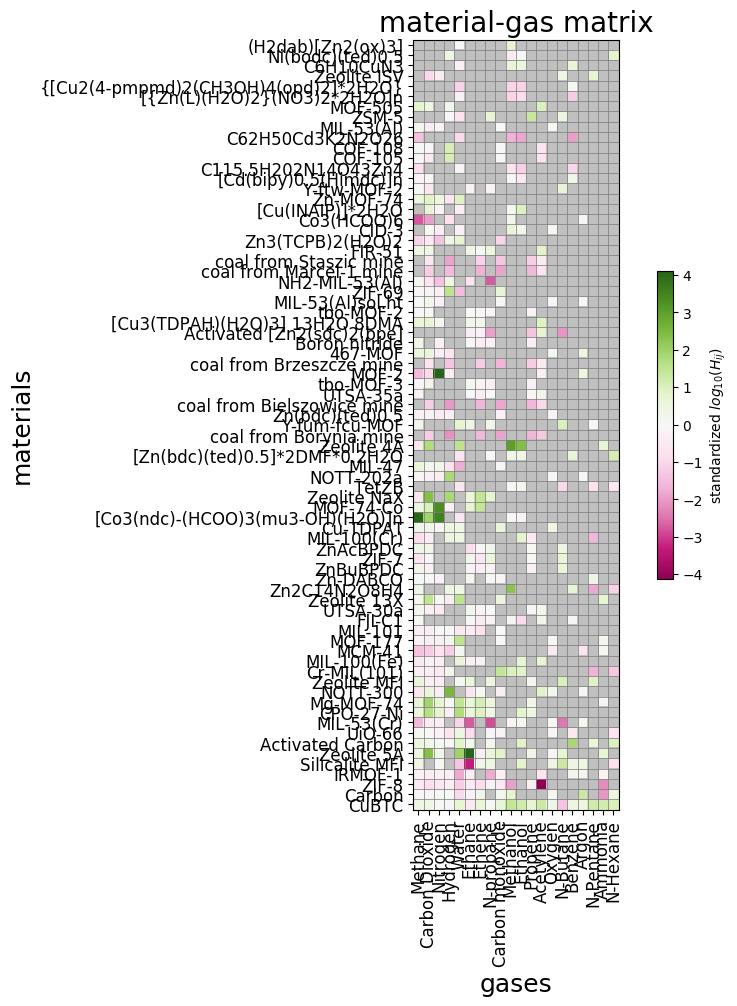

In [23]:
spy_H = deepcopy(H)
spy_H[ismissing.(H)] .= 0.0

spy_H2 = fill(0.0, size(H))
spy_H2[.!ismissing.(H)] .= 0
spy_H2[ismissing.(H)] .= 1

fig, ax = subplots(figsize=(10, 10))
img = ax.pcolormesh(spy_H, cmap="PiYG", 
    vmax=maximum(abs.(spy_H)), vmin=-maximum(abs.(spy_H)))
cbar = colorbar(img, label=L"standardized $log_{10}(H_{ij})$", shrink=0.4)

#cmap = plt.get_cmap("PiYG")
#colors = cmap(collect(1:cmap.N))
colors = Array{Float64, 2}(undef, 2, 4)
colors[1, :] .= [255.0, 255.0, 255.0, 0.0] ./ 255
colors[2, :] .= [192., 192., 192., 255.] ./ 255
cmap = matplotlib.colors.ListedColormap(colors)
img = ax.pcolormesh(spy_H2, cmap=cmap)

# grid lines
for x = 1:nm
    plot([0, ng], [x, x], linewidth=0.55, color="gray")
end
for y = 1:ng
    plot([y, y], [0, nm], linewidth=0.55, color="gray")
end
ax.set_aspect("equal")
ax.set_title("material-gas matrix", fontsize=20)
ax.set_xlabel("gases", fontsize=18)
ax.set_ylabel("materials", fontsize=18)
# TODO make missing values black to distinguish between actual 0 and missing.
# TODO xticks, yticks with material and gas names
xticks(collect(1:ng) .- 0.5, gases, rotation=90, fontsize=12)
yticks(collect(1:nm) .- 0.5, materials, fontsize=12);
plt.savefig("prelim_H_matrix.png", dpi=300, format="png")

## work with `H'`, i.e. transpose of `H` to add row offsets via `LowRankModels.jl`

In [24]:
H = collect(H')
MSE = collect(MSE')

20×75 Array{Union{Missing, Float64},2}:
 0.000150845  0.000180336  8.18738e-5   …   missing     missing      missing 
 0.000171572  0.000341132  0.000184869      missing     missing      missing 
 0.000182058  0.000186144  0.000610311      missing     missing      missing 
 0.000266674  0.000173587  0.000268759      missing    0.000182377   missing 
 0.00251787   0.0267389    0.0117355       0.0301306    missing     0.0251815
 0.0120056    0.000369477  0.000107504  …   missing     missing      missing 
 0.00184847   0.0030045    5.78383e-5       missing     missing      missing 
 0.000646075   missing     0.0016902        missing     missing      missing 
 0.000427531  0.00021055   5.21406e-5       missing     missing      missing 
 0.00103975   0.00062596   0.00407085      0.0230224   0.00580123   0.0428662
 0.00200417    missing      missing     …  0.014486    0.00531574    missing 
 0.000264547   missing     0.00154777       missing     missing      missing 
 0.00068107    missing  

# find the optimal low rank model through cross-validation

In [26]:
const ids_obs = observations(H) # returns tuple of observations
nb_obs = length(ids_obs)
println("# observations = ", nb_obs)
println("fraction entries that are observed = ", nb_obs / nm / ng)

# observations = 522
fraction entries that are observed = 0.348


In [29]:
# sanity check
for obs in ids_obs
    @assert ! ismissing(H[obs...])
end

### set up generalized low rank model for practice

we'll train on all data for practice to see how it works.

TODO: ask Prof. Udell why offsets are not regularized.

In [40]:
# k = rank of matrix
# γ = regularization param
# obs = which observations we train on.
# Udell: do we need to look at ch? does it tell us if it fails?
function fit_glrm(k::Int, γ::Float64, obs::Array{Tuple{Int64,Int64}, 1}; verbose::Bool=true)
    rg = QuadReg(γ / ng) # quadratic regularizer on gas matrix G
    rm = QuadReg(γ / nm) # quadratic regularizer on MOF matrix M
    @assert size(H) == (ng, nm)

    glrm = GLRM(H, QuadLoss(), rg, rm, k, obs=obs, offset=true)
#    init_svd!(glrm)
    G, M, ch = fit!(glrm, verbose=verbose) # H' ~ G' * M well, our mathy H
    @assert size(G)[2] == ng
    @assert size(M)[2] == nm

    @assert isapprox(impute(glrm), G' * M)
    return G, M, glrm, ch
end

G, M, glrm, ch = fit_glrm(2, 30.0, ids_obs)

Fitting GLRM
Iteration 10: objective value = 227.35185512881873
Iteration 20: objective value = 196.51137009337452


([0.47048595920383995 -0.004231923413682871 … 0.15154524481122314 0.4185859513390903; 1.0 1.0 … 1.0 1.0], [0.2836655740170019 0.10632109077407917 … 0.5765888465311543 0.12372745034234998; 0.5169739346789295 0.022096947561995532 … 0.4259384702094722 0.545663364345936], GLRM(Union{Missing, Float64}[0.33185596155300556 -0.07640543553539392 … missing missing; 0.4083695028761048 -0.12116318535520419 … missing missing; … ; 1.1724657427766831 -2.0287955148076913 … missing missing; 1.0865671735726963 0.545197317115467 … 0.8258342449501624 missing], Loss[QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())  …  QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1

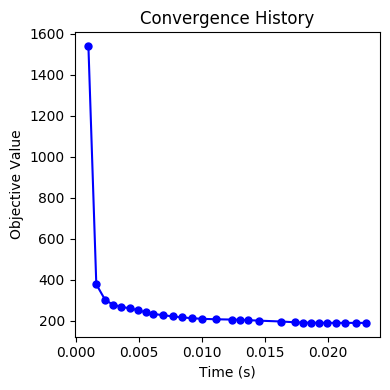

In [41]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(ch.times, ch.objective, color="b", marker="o", markersize=5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Objective Value")
ax.set_title("Convergence History")
plt.tight_layout()
plt.show()

### split observations into K-folds

TODO: ask Prof. Udell how this works when a row/col in the training set is fully empty.

the indices e.g. `kfolds[1]` below in `kfolds` refer to `ids_obs`, the index of the observation, *not* the entry of `H`.

* `kfolds[k]` gives train/test indices for fold `k`.
* `kfolds[k][1]` gives indices for training
* `kfolds[k][2]` gives indices for testing

In [60]:
kfolds = KFold(length(ids_obs), n_folds=10, shuffle=true) #length(ids_obs)) # LOO MAKE SURE shuffle=true
n_folds = length(kfolds)
println("splitting data into ", n_folds, " folds...")
if n_folds != length(ids_obs) # LOO
    @warn "some rows/cols are probably empty during training with this naive splitting procedure"
end

splitting data into 10 folds...


┌ Warning: some rows/cols are probably empty during training with this naive splitting procedure
└ @ Main In[60]:5


visualize the fold matrix

`test_fold_matrix[i, j]` gives the test fold that observation $(i, j)$ belongs to.

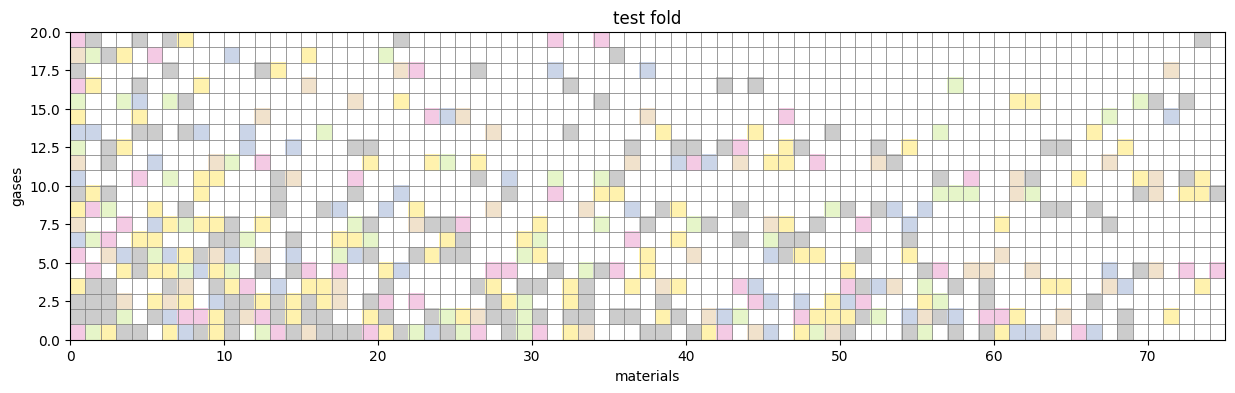

In [197]:
test_fold_matrix = Int.(zeros(size(H)))
for (k, fold) in enumerate(kfolds)
    for ix in fold[2] # test indices
        test_fold_matrix[ids_obs[ix][1], ids_obs[ix][2]] = k
    end
end

cmap = plt.get_cmap("Pastel2")
colors = cmap(collect(1:cmap.N))
#colors = Array{Float64, 2}(undef, 6, 4)
colors[1, :] .= [0.0, 0.0, 0.0, 0.0] ./ 255
# colors[2, :] .= [128., 0., 0., 255.] ./ 255
# colors[3, :] .= [170., 255., 195., 255.] ./ 255
# colors[4, :] .= [145., 30., 180., 255.] ./ 255
# colors[5, :] .= [255., 250., 200., 255.] ./ 255
# colors[6, :] .= [0., 130., 200., 255.] ./ 255
cmap = matplotlib.colors.ListedColormap(colors)

figure(figsize=(15, 15*ng/nm))
pcolormesh(test_fold_matrix, cmap=cmap)
# grid lines
for x = 1:size(test_fold_matrix)[1]
    plot([0, size(test_fold_matrix)[2]], [x, x], linewidth=0.55, color="gray")
end
for y = 1:size(test_fold_matrix)[2]
    plot([y, y], [0, size(test_fold_matrix)[1]], linewidth=0.55, color="gray")
end
# TODO xticks, yticks
xlabel("materials")
ylabel("gases")
title("test fold")
ax = gca()
ax.set_aspect("equal")
# TODO put legend in there for the fold
savefig("prelim_fold_matrix.png", dpi=300, format="png")

## functions to evaluate Spearmann-rank correlation, stratified among gas

In [107]:
"""
return indices of observations in H that involve gas g only.
"""
function ids_obs_gas(ids_obs::Array{Tuple{Int, Int}, 1}, g::Int)
    ids_obs_g = Tuple{Int64, Int64}[]
    for id_obs in ids_obs
        # if gas g is involved in this observation, push it
        if g == id_obs[1] # remember: H is transposed here.
            push!(ids_obs_g, id_obs)
        end
    end
    return ids_obs_g
end

"""
compute the spearmann rank correlation coeff between observations and predictions, 
     under constraint that these observations correspond to gas g.
     also return the number of observations with this gas.
"""
function ρ_g(H::Array{Union{Float64, Missing}, 2}, Ĥ::Array{<:Number, 2}, 
             g::Int, ids_obs::Array{Tuple{Int, Int}, 1})
    # find all observations belonging to gas g
    ids_obs_g = ids_obs_gas(ids_obs, g)
    
    # construct arrays of truth/prediction of H for this gas
    H_g = [H[i, j] for (i, j) in ids_obs_g] # truth
    Ĥ_g = [Ĥ[i, j] for (i, j) in ids_obs_g] # prediction
    
    if length(ids_obs_g) in [0, 1]
        error("only zero or one obs, can't compute spearmann rank")
    end
    
    ρg = corspearman(H_g, Ĥ_g) # Spearmann rank correlation coefficient
    nb_obs_gas_g = length(ids_obs_g) # number of observations with this gas
    if isnan(ρg)
        println(H_g)
        println(Ĥ_g)
        error("ρg == NaN ...")
    end
    return nb_obs_gas_g, ρg 
end

"""
if ρᵧ is Spearmann rank corr. coeff. for gas γ, then this function returns average ρᵧ, weighted by
    the number of observations for that gas.
"""
function ρ_wt_avg(H::Array{Union{Float64, Missing}, 2}, Ĥ::Array{<:Number, 2}, ids_obs::Array{Tuple{Int, Int}, 1})
    ρ = 0.0
    total_nb_obs = 0
    for g = 1:ng
        nb_obs_gas_g, ρg = ρ_g(H, Ĥ, g, ids_obs)
        ρ += ρg * nb_obs_gas_g
        total_nb_obs += nb_obs_gas_g
    end
    @assert total_nb_obs == length(ids_obs)    
    return ρ / total_nb_obs
end

ρ_wt_avg

## run cross-validation

specify the range of ranks and regularization params we aim to cover

In [108]:
ks = [1, 2, 3, 4] # ranks
γs = 10.0 .^ range(1.0, 3.5, length=15); # regularization params

map rank to color for data visualizations

In [109]:
cmap = PyPlot.matplotlib.cm.viridis
norm = PyPlot.matplotlib.colors.Normalize(vmin=minimum(ks), vmax=maximum(ks))
rank_to_color = PyPlot.matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba

PyObject <bound method ScalarMappable.to_rgba of <matplotlib.cm.ScalarMappable object at 0x7f833c992748>>

In [153]:
"""
do k-folds cross validation, return matrix with test predictions
"""
function do_cv(kfolds, k, γ, ids_obs)
    # pre-allocate test set predictions. fill in as we loop over the folds.
    H_pred = [NaN for g = 1:ng, m = 1:nm]
    @assert size(H_pred) == size(H)

    # loop over folds
    for (train_ids, test_ids) in kfolds
        # train model on training data
        G, M, glrm, ch = fit_glrm(k, γ, ids_obs[train_ids], verbose=false)

        # assess error on test data
        Ĥ = impute(glrm) # predictions
        for (g, m) in ids_obs[test_ids]
            @assert isnan(H_pred[g, m]) "data pt. in test set > 1 times!"
            H_pred[g, m] = Ĥ[g, m]
        end
    end
    
    # sanity check
    for g = 1:ng
        for m = 1:nm
            if ismissing(H[g, m])
                @assert isnan(H_pred[g, m])
            else
                @assert ! isnan(H_pred[g, m])
            end
        end
    end
    
    return H_pred
end

H_pred = do_cv(kfolds, 1, 0.1, ids_obs)

20×75 Array{Float64,2}:
 0.553732    0.18177      -1.12389    -0.468163  …  NaN          NaN        
 0.469239   -0.040778     -1.06011    -0.528807     NaN          NaN        
 0.502138   -0.040778     -1.03934    -0.47583      NaN          NaN        
 0.540711    0.00649878   -0.862839   -0.572452       0.140218   NaN        
 0.505491    0.0692979    -1.15323    -0.353656     NaN            0.828198 
 0.553732    0.0234973    -1.12608    -0.463673  …  NaN          NaN        
 0.479904    0.18177      -1.08897   NaN            NaN          NaN        
 0.493449  NaN            -1.15323    -0.328355     NaN          NaN        
 0.540711    0.0692979    -1.11601    -0.572452     NaN          NaN        
 0.469239   -0.0633571    -1.03934   NaN              0.606851     0.0545818
 0.479904  NaN           NaN         NaN         …    0.606851   NaN        
 0.493449  NaN            -1.06011   NaN            NaN          NaN        
 0.472137  NaN            -0.862839   -0.435615     

run `n_folds` cross validation, store test error for each $(k, \gamma)$ combo

In [172]:
# TODO ask Prof. Udell if it makes any sense to regularize X, Y separately
progress_meter = Progress(length(ks) * length(γs)) # progress meter

cv_results = Dict(k => Dict(
                            "rmsd"     => zeros(length(γs)), # root mean square deviation, one for each γ
                            "ρ_wt_avg" => zeros(length(γs)) # spearmann-rank, one for each γ
                            )
                for k in ks)

H_actual = [H[i, j] for (i, j) in ids_obs]
# loop over ranks
for (i_k, k) in enumerate(ks)
    # loop over regularization params
    for (i_γ, γ) in enumerate(γs)
        
        H_pred = do_cv(kfolds, k, γ, ids_obs)
        
        ProgressMeter.next!(progress_meter)
        @assert all(.! isnan.([H_pred[i, j] for (i, j) in ids_obs])) "not all data served as test!"
        
        # put predictions in an array
        Ĥ = [H_pred[i, j] for (i, j) in ids_obs] # each served as test data pt once
        
        cv_results[k]["rmsd"][i_γ] = rmsd(Ĥ, H_actual) # root mean square deviation (from StatsBase.jl)
        cv_results[k]["ρ_wt_avg"][i_γ] = ρ_wt_avg(H, H_pred, ids_obs)
    end
end
cv_results

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


Dict{Int64,Dict{String,Array{Float64,1}}} with 4 entries:
  4 => Dict("rmsd"=>[1.21919, 1.0632, 0.970082, 0.961354, 0.922932, 0.87119, 0.…
  2 => Dict("rmsd"=>[1.09001, 1.07451, 0.947293, 0.941673, 0.942447, 0.90243, 0…
  3 => Dict("rmsd"=>[1.11494, 1.0618, 1.00023, 0.94339, 0.934705, 0.895617, 0.8…
  1 => Dict("rmsd"=>[0.863487, 0.863724, 0.86326, 0.863631, 0.863601, 0.863307,…

visualize average `n_fold` test set error against regularization param $\gamma$ for different ranks

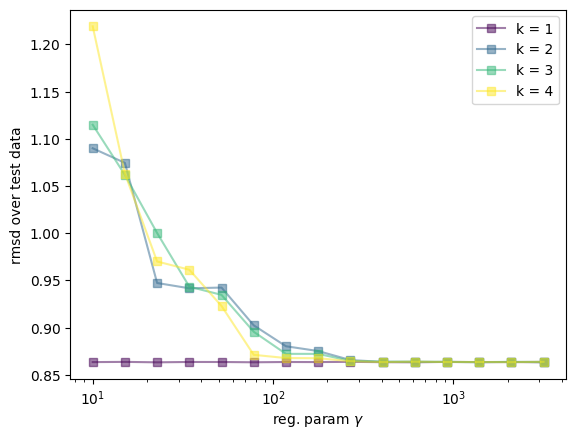

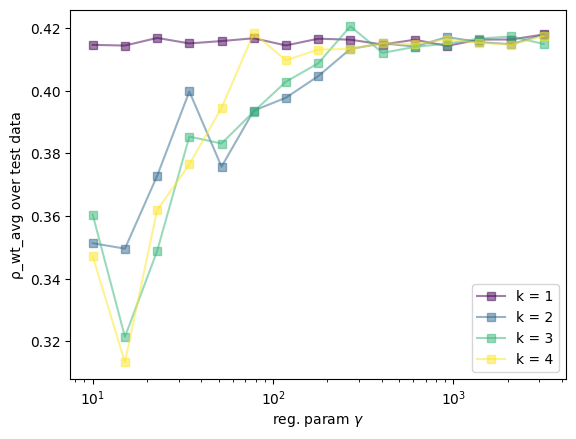

In [173]:
for metric in ["rmsd", "ρ_wt_avg"]
    figure()
    xlabel(L"reg. param $\gamma$")
    ylabel(metric * " over test data")
    for k in ks
        plot(γs, cv_results[k][metric], 
            label=@sprintf("k = %d", k), marker="s", 
            color=rank_to_color(k), alpha=0.5)
    end
    xscale("log")
    legend()
end
# Udell ?: should call when we only have MOF offsets, k = 0 or k = 1?
# Udell ?: if we are not regularizing the offsets, why is k=1 fixed? do we need to change max_iter or something?

## select optimal model

In [157]:
metric = "ρ_wt_avg"
metric = "rmsd"
@info "selecting model with optimal " * metric

opt_k = -1
opt_γ = NaN
i_γ = -1
if metric == "ρ_wt_avg"
    # select model with *max* rank corr coeff
    max_metric_of_k = [maximum(cv_results[k][metric]) for k in ks] # metric as a function of k
    opt_k = ks[argmax(max_metric_of_k)] # optimum rank
    i_γ = argmax(cv_results[opt_k][metric])
    opt_γ = γs[i_γ]
elseif metric == "rmsd"
    # select model with *min* rank corr coeff
    min_metric_of_k = [minimum(cv_results[k][metric]) for k in ks] # metric as a function of k
    opt_k = ks[argmin(max_metric_of_k)] # optimum rank
    i_γ = argmin(cv_results[opt_k][metric])
    opt_γ = γs[i_γ]
end

@printf("optimum γ = %.3f, optimum k = %d\n", opt_γ, opt_k)

┌ Info: selecting model with optimal rmsd
└ @ Main In[157]:3


optimum γ = 117.877, optimum k = 2


### redo CV with optimal settings
store correlation coeff for each gas too

In [180]:
H_pred = do_cv(kfolds, opt_k, opt_γ, ids_obs) # matrix of test predictions

ρ_gs = zeros(ng)
for g = 1:ng
    ρ_gs[g] = ρ_g(H, H_pred, g, ids_obs)[2]
end

### Look at spearmann rank for each gas in the optimal model

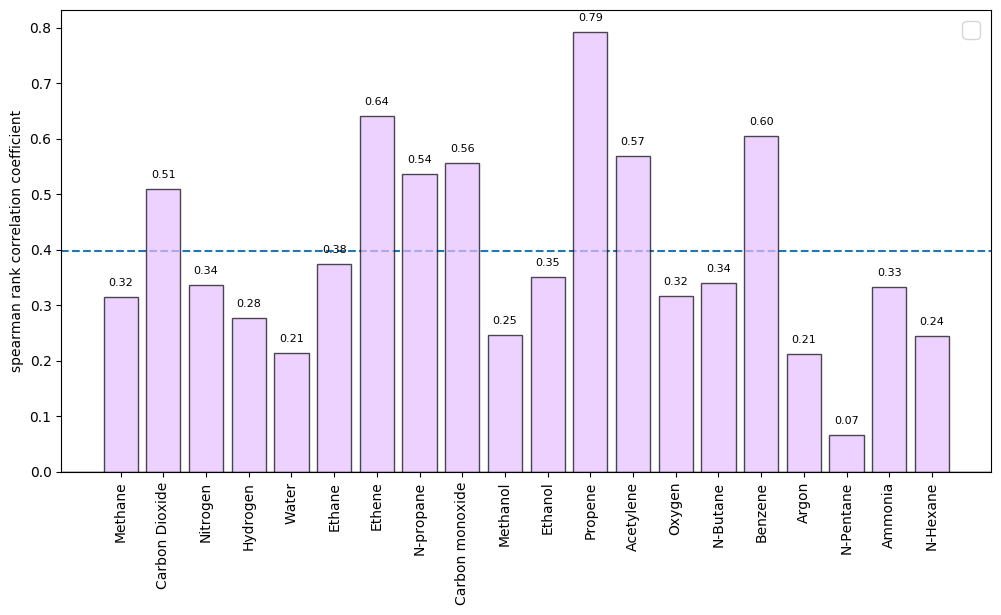

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: Use

In [182]:
fig, ax = plt.subplots(figsize=(12, 6))

brs = ax.bar(1:length(gases), ρ_gs, fc="#e6beff", ec="k", alpha=0.7)
for (i, ρ_g_i) in enumerate(ρ_gs)
    ax.text(i, abs(ρ_g_i)+0.02, @sprintf("%.2f", ρ_g_i), ha="center", fontsize=8)
end
xlim = ax.get_xlim()
ax.plot(xlim, [0, 0], c="#a9a9a9", alpha=0.7, zorder=0.5)
ax.set_xlim(xlim)
ax.set_xticks(1:length(gases))
ax.set_xticklabels(gases, rotation=90)
ax.set_ylabel("spearman rank correlation coefficient")
# if 1 in ks
#     ax.scatter(1:length(gases), cv_results[1]["ρ_g"][:, 1], marker="*", s=82, 
#             fc="#aaffc3", ec="k", alpha=0.7, label="k = 1 model", zorder=99)
# end
axhline(y=cv_results[opt_k]["ρ_wt_avg"][i_γ], linestyle="--", zorder=0)
ax.legend(prop=Dict("size" => 16))
plt.show()

### parity plot over `n_folds`-cross validation

In [183]:
H_actual = [H[i, j] for (i, j) in ids_obs] # array
Ĥ = [H_pred[i, j] for (i, j) in ids_obs]; # array
mses = [MSE[i, j] for (i, j) in ids_obs]

function R_squared(H_actual, Ĥ)
    return 1.0 - sum((Ĥ .- H_actual) .^ 2) / sum((Ĥ .- mean(H_actual)) .^ 2)
end

R_squared (generic function with 1 method)

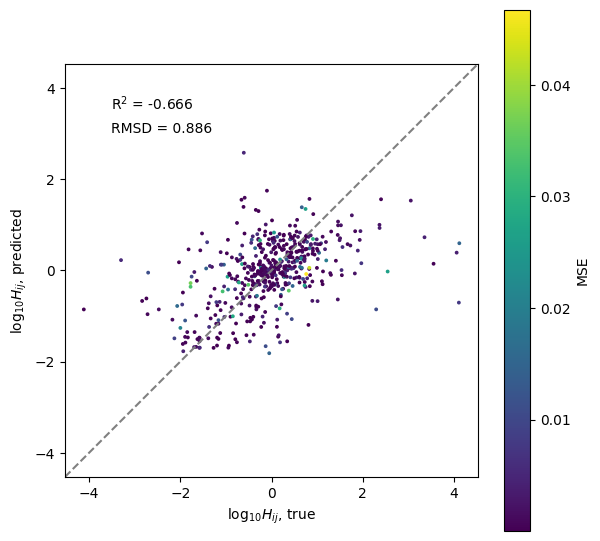

R² = -0.6663697257290524


In [184]:
R² = R_squared(H_actual, Ĥ)
@show R²

fig, ax = subplots(figsize=(6, 6))
xlabel(L"$\log_{10} H_{ij}$, true")
ylabel(L"$\log_{10} H_{ij}$, predicted")
#hexbin(H_actual, H_pred, cmap="Greens", mincnt=1) #mincnt=1 makes bins white
scatter(H_actual, Ĥ, s=3, c=mses)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(xlim, xlim, linestyle="--", color="gray")
ax.text(xlim[1]+1, xlim[2]-1, @sprintf("R\$^2\$ = %.3f", R²))
ax.text(xlim[1]+1, xlim[2]-1.5, @sprintf("RMSD = %.3f", rmsd(H_actual, Ĥ)))
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.set_aspect("equal")
plt.tight_layout()
colorbar(label="MSE")
plt.savefig("prelim_results.png", dpi=300, format="png")

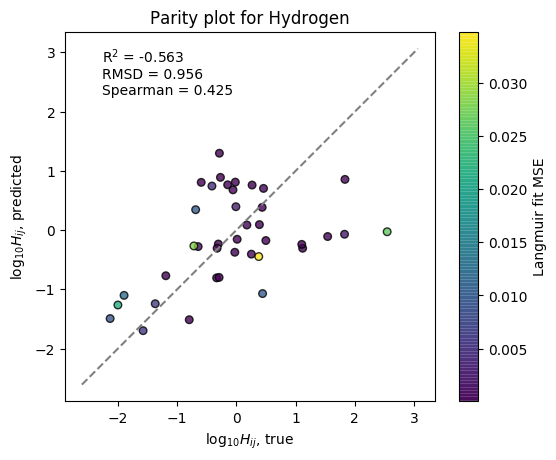

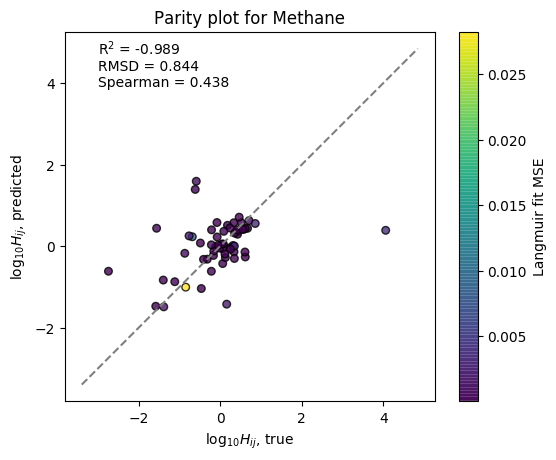

2-element Array{Nothing,1}:
 nothing
 nothing

In [204]:
function gas_parity_plot(gas::Union{Int, AbstractString})
    if typeof(gas) <: AbstractString
        @assert gas in gases
        gas = findfirst(gas .== gases)
    end
                                                    
    H_actual_g = [H[i, j] for (i, j) in ids_obs if i == gas] # array
    Ĥ_g = [H_pred[i, j] for (i, j) in ids_obs if i == gas] # array
    mses_g = [MSE[i, j] for (i, j) in ids_obs if i == gas]
                                                    
    R² = R_squared(H_actual_g, Ĥ_g)
    ρ = corspearman(H_actual_g, Ĥ_g)
    figure()
    scatter(H_actual_g, Ĥ_g, c=mses_g, s=30, ec="k", alpha=0.8)
    xlabel(L"$\log_{10} H_{ij}$, true")
    ylabel(L"$\log_{10} H_{ij}$, predicted")
    colorbar(label="Langmuir fit MSE")
    ax = gca()
    
    xlim = [ax.get_xlim()...]
    ylim = [ax.get_ylim()...]
    
    lim = diff(xlim)[1] > diff(ylim)[1] ? xlim : ylim
    plot(lim.*1.1, lim.*1.1, linestyle="--", color="gray")
#     xlim(lim.*1.1)
#     ylim(lim.*1.1)
    text(lim[1]+0.1, lim[2]-0.5, @sprintf("R\$^2\$ = %.3f\nRMSD = %.3f\nSpearman = %.3f", 
                                                R², 
                                                rmsd(H_actual_g, Ĥ_g),
                                                ρ))

    title("Parity plot for " * gases[gas])
    ax.set_aspect("equal")
    return nothing
end
                                                    
gas_parity_plot.(["Hydrogen", "Methane"])

## viz offsets and latent space on fully trained model

In [205]:
G, M, glrm, ch = fit_glrm(opt_k, opt_γ, ids_obs, verbose=false)

([-0.5312758529460768 0.17432303821606118 … 0.05818813106584101 -0.20192393940849715; 1.0 1.0 … 1.0 1.0], [0.41613949378522835 -0.11757304497229012 … -0.3172920366014098 0.00698248259764628; 0.5270753177922004 0.01150323923574195 … 0.3208264346538835 0.43557970840956867], GLRM(Union{Missing, Float64}[0.33185596155300556 -0.07640543553539392 … missing missing; 0.4083695028761048 -0.12116318535520419 … missing missing; … ; 1.1724657427766831 -2.0287955148076913 … missing missing; 1.0865671735726963 0.545197317115467 … 0.8258342449501624 missing], Loss[QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())  …  QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLo

### offsets $\mu_i$ representing material biases

In [206]:
these_means = [mean(skipmissing(H[:, i])) for i = 1:nm]

75-element Array{Float64,1}:
  0.5176472228114438  
  0.006210920506583664
 -1.075006847694326   
 -0.45010441393240413 
 -0.055757391744365836
  1.0115621065027904  
  0.591718197487388   
 -0.2559459000105445  
 -1.0157242653180811  
  0.7820878092524444  
  0.7429816786116524  
  0.24336502158992354 
  0.40809999289594745 
  ⋮                   
 -0.017212834459212133
  0.10845839694173831 
 -1.5617947764294389  
 -0.0469795713821346  
  0.3778103061527379  
  0.6405465763322086  
 -0.8284977955212598  
 -0.779962217424111   
 -0.06217511521235561 
  0.4181541031291308  
  0.20363918267647035 
  0.441390015436892   

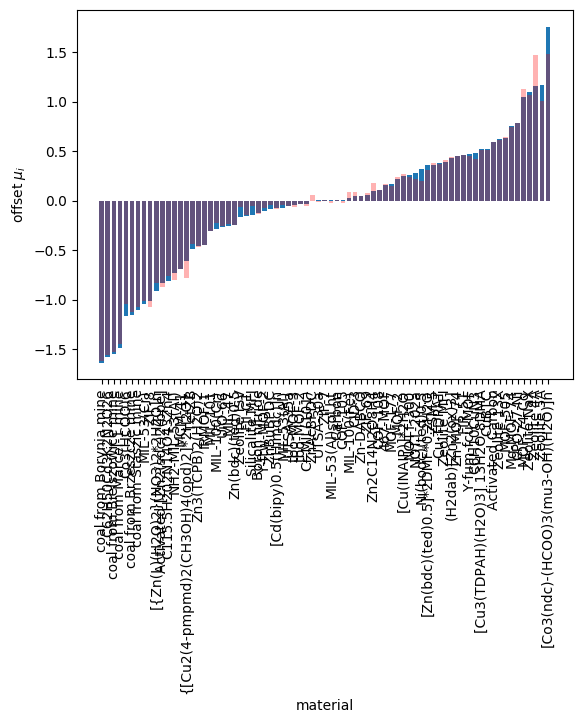

In [207]:
μ = M[end, :]

figure()
bar(1:nm, μ[sortperm(μ)])
bar(1:nm, these_means[sortperm(μ)], color="red", alpha=0.3)
xlabel("material")
ylabel(L"offset $\mu_i$")
xticks(1:nm, materials[sortperm(μ)], rotation=90);

In [ ]:
function plot_offset(μ::Array{Float64, 1}, show_all_materials=false)
    N = length(μ)
    sorted_idx = sortperm(μ)[end:-1:1]
    color = "#469990"
    edgecolor = "k"
    if N > 40 && !show_all_materials
        fig, ax = plt.subplots(figsize=(20,8))
        ax.bar(1:19, μ[sorted_idx][1:19], 0.8, linewidth=1.5, label="Offset", color=color, edgecolor=edgecolor)
        ax.bar(21:40, μ[sorted_idx][end-19:end], 0.8, linewidth=1.5, label="Offset", color=color, edgecolor=edgecolor)
        ax.plot([-1, 19.7], [0, 0], c=edgecolor, lw=2.5)
        ax.plot([20.3, 41], [0, 0], c=edgecolor, lw=2.5)
        ax.plot([19.7, 19.9], [0, 0.5], c=edgecolor, lw=2.5)
        ax.plot([19.9, 20.1], [0.5, -0.5], c=edgecolor, lw=2.5)
        ax.plot([20.1, 20.3], [-0.5, 0], c=edgecolor, lw=2.5)
        ax.set_xlim(0, 41)
    else
        fig, ax = plt.subplots(figsize=(20,8))
        ax.bar(1:N, μ[sorted_idx], 0.8, linewidth=1.5, label="Offset", color=color, edgecolor=edgecolor)
        xlim = ax.get_xlim()
        ax.plot(xlim, [0, 0], c=edgecolor, lw=3.5, alpha=0.5)
        ax.set_xlim(0, N)
    end
    
    
    ax.set_ylabel(L"Material offset $\mathbf{\mu}$", fontsize=16)
    xlabels = [material for material in materials[sorted_idx]]
    if N > 40 && !show_all_materials
        ax.set_xticks(1:41)
            ax.set_xticklabels(vcat(vcat(xlabels[1:19], ["..."]), xlabels[end-19:end]), rotation=90, fontsize=16)
        for tick in ax.get_xticklabels()
            if tick.get_text() == "..."
                tick.set_rotation(0)
            end
        end
    else
        ax.set_xticks(1:length(xlabels))
        ax.set_xticklabels(xlabels, rotation=90, fontsize=16)
    end
    #ax.set_title(mof_or_gas + ' biases from RecSys model', fontsize=16)
    plt.tight_layout()
    plt.savefig("prelim_offset.png", dpi=300, format="png")
    plt.show()
end
asdf = plot_offset(μ, false)

### depreciated: I don't think this splitting is rigorously justified

In [54]:
# # Cory: I don't think this biased splitting is rigorously justified.
# function k_fold_split(H::Array{Union{Missing, Float64}, 2}, k::Int; max_iter=1000, use_weighted_sampling::Bool=false)
#     #@assert k > 1 "Choose a `k` greater than 1, otherwise this function is pointless"
#     @printf("Splitting matrix into %d folds\n", k)
#     if use_weighted_sampling
#         @warn "Warning: You are using weighted sampling. Whether this is applicable in k-fold cross validation is unclear at the moment."
#     end
#     fold_matrix = fill(0, size(H))
#     all_k_folds_not_represented_in_each_column = true
#     n_iteration = 0

#     while all_k_folds_not_represented_in_each_column
#         n_iteration += 1
#         all_k_folds_not_represented_in_each_column = false
#         for j_col = 1:size(H)[2]
#             # Grabs all available indices in row `i_row`
#             i_indices = findall(.!ismissing.(H[:,j_col]))
#             # As long as there are enough data points to distribute between `k` folds, we'll equally distribute them.
#             while length(i_indices) >= k
#                 for fold = 1:k
#                     i = rand(1:length(i_indices))
#                     fold_matrix[i_indices[i], j_col] = fold
#                     deleteat!(i_indices, i)
#                 end
#             end
#             # If there are leftover data points (i.e. #data points left < `k`), we'll randomly assign them into folds
#             for i in i_indices
#                 if use_weighted_sampling
#                     items = collect(1:k)
#                     weights = [sum(fold_matrix[:, j_col] .!= _k .| fold_matrix[:, j_col] .!= 0) for _k = 1:k]
#                     fold_matrix[i, j_col] = sample(items, Weights(weights))
#                 else
#                     fold_matrix[i, j_col] = rand(1:k)
#                 end
#             end
#         end
#         # We make sure we have enough data points in the columns as well
#         for i_row = 1:size(H)[1]
#             unique_folds = unique(fold_matrix[i_row, :])
#             if length(unique_folds) <= k
#                 all_k_folds_not_represented_in_each_column = true
#                 break
#             end
#         end

#         # If too many iteration are performed an Exception is raised.
#         if n_iteration >= max_iter
#             error("Maximum number of iterations reached. Try changing the `max_iter` argument.")
#         end
#     end
    
#     for i = 1:size(H)[1]
#         for j = 1:size(H)[2]
#             if ismissing(H[i,j])
#                 continue
#             else
#                 @assert fold_matrix[i,j] != -1 "A non-NaN value was not put in a fold"
#             end
#         end
#     end
    
#     @printf("Number of iterations required to split data into %d-folds: %d\n", k, n_iteration)
#     for fold = 1:k
#         @printf("Number of data points in fold %d: %d\n", fold, sum(fold_matrix .== fold))
#     end
#     @printf("Total number of data points: %d\n", sum(.!ismissing.(H)))
#     @printf("-----------------------------------\n")
#     return fold_matrix
# end

# fold_matrix = k_fold_split(H, 3, max_iter=100000, use_weighted_sampling=true)
# temp_fold_matrix = replace(fold_matrix, 0 => missing)
# kfolds = [(findall(collect(skipmissing(temp_fold_matrix))[:] .!= k), 
#            findall(collect(skipmissing(temp_fold_matrix))[:] .== k)) 
#                 for k = 1:length(unique(fold_matrix))-1]
# n_folds = length(kfolds)

In [ ]:
# fig, ax = plt.subplots(figsize=(16, 8))
# bars = ρ_g_no_wts[opt_k][γ_idx]
# avg_bar = mean(bars)
# weighted_avg_bar = maximum(max_spearman)

# brs = ax.bar(1:length(gases), bars, fc="#911eb4", ec="k", alpha=0.7)
# new_order = 

# xlim = ax.get_xlim()
# ax.plot(xlim, [0, 0], c="#a9a9a9", linewidth=4, alpha=0.7, zorder=0.5)
# ax.plot(xlim, [avg_bar, avg_bar], c="#e6194B", alpha=0.8, zorder=1.5, linewidth=4,
#     linestyle="--", label="Average Spearman Ranking Correlation Coefficient")
# ax.plot(xlim, [weighted_avg_bar, weighted_avg_bar], c="#42d4f4", alpha=0.8, zorder=1.5, linewidth=4,
#     linestyle="--", label="Weighted Average Spearman Ranking Correlation Coefficient")
# for (i, bar) in enumerate(bars)
#     if bar < 0
#         ax.text(i, bar-0.05, Int(ρ_g_just_wts[opt_k][γ_idx][i]), ha="center", va="center", fontsize=10, zorder=999)
#     else
#         ax.text(i, bar+0.025, Int(ρ_g_just_wts[opt_k][γ_idx][i]), ha="center", fontsize=10, zorder=999)
#     end
# end
# if 1 in ks
#     ax.scatter(1:length(gases), ρ_g_no_wts[1][argmax(ρ_g_wt_avg[1])], marker="*", s=82, 
#             fc="#aaffc3", ec="k", alpha=0.7, label="k = 1 model", zorder=99)
#     #brs = ax.bar(1:length(gases), ρ_g_no_wts[1][argmax(ρ_g_wt_avg[1])], fc="#911eb4", ec="#aaffc3", alpha=0.8, zorder=2)
# end
# ax.set_xlim([0, length(gases)+1])
# ax.set_ylim([-1.1, 1.1])
# ax.set_xticks(1:length(gases))
# ax.set_xticklabels(gases, rotation=90)
# ax.set_ylabel("Spearman Ranking Correlation Coefficients")
# ax.legend(loc=3, prop=Dict("size" => 16))
# ax.grid("on", alpha=0.5)
# plt.tight_layout()
# plt.savefig("gas_spearman_ranking.png", format="png", dpi=300)
# plt.show()